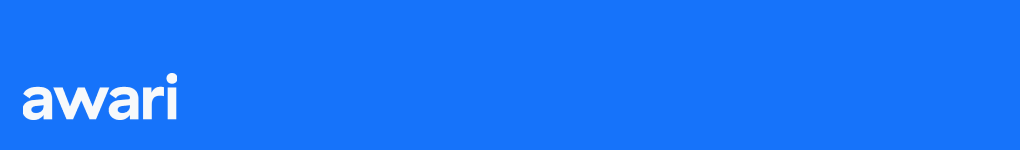

Prática da **Aula 8: Spark e Fontes de Dados**, do curso de **Engenharia de Dados** da **[Awari](https://awari.com.br/)**. 

---

In [1]:
!pip install boto3

import pyspark
import boto3

from io import StringIO 
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType 
from pyspark.sql.types import ArrayType, DoubleType, BooleanType
from pyspark.sql.functions import col,array_contains

# Criando um contexto

In [2]:
# Import SparkSession
from pyspark.sql import SparkSession

# Criando uma sessão com o Spark que existe localmente(atualmente configurado junto com o JupyterLab)
spark = SparkSession.builder \
      .master("local[1]") \
      .appName("AwariAula08") \
      .getOrCreate() 

# Criando um RDD
- Resilient Distributed Datasets, abstraem um conjunto de objetos distribuídos no cluster, geralmente executados na memória principal e podem depois serem salvos em um Haddop, Banco de Datos, arquivo, etc, quando você carrega 
- Um RDD ele é um dado IMUTAVEL e e semelhante a uma lista em Python, com a diferença de que o RDD é calculado em vários processos espalhados por vários servidores físicos, também chamados de nós em um cluster, enquanto uma coleção Python vive e processa em apenas um processo.
- RDD é mais utilizado quando precisamos trabalhar mais baixo nivel manipulando diretamente o DataSet

In [3]:
# Partir da memoria
dataList = [("Java", 20000), ("Python", 100000), ("Scala", 3000)]
rdd=spark.sparkContext.parallelize(dataList)
rdd.first()

('Java', 20000)

In [4]:
# A Partir de um arquivo
rdd2 = spark.sparkContext.textFile("./arquivos/customers.csv")
header = rdd2.first()
rdd2 = rdd2.filter(lambda row: row != header)
rdd2.take(5)

['1,Male,19,15000,39,Healthcare,1,4',
 '2,Male,21,35000,81,Engineer,3,3',
 '3,Female,20,86000,6,Engineer,1,1',
 '4,Female,23,59000,77,Lawyer,0,2',
 '5,Female,31,38000,40,Entertainment,2,6']

# RDD Operações
Transformações no Spark etorna outro RDD e essas transformações são lentas, o que significa que elas não são executadas até que você chame uma ação no RDD. Algumas transformações em RDD's são flatMap(), map(), reduceByKey(), filter(), sortByKey() e retornam um novo RDD ao invés de atualizar o atual.

# RDD Ações
Retorna os valores de um RDD para um nó de driver. Em outras palavras, qualquer função RDD que retorna um não RDD é considerada uma ação. Algumas ações no RDD são count(), collect(), first(), max(), reduce() and more.

# PySpark DataFrame
DataFrame é uma coleção distribuída de dados organizados em colunas nomeadas. É conceitualmente equivalente a uma tabela em um banco de dados relacional ou um quadro de dados em R/Python, mas com otimizações mais ricas sob o capô. Os DataFrames podem ser construídos a partir de uma ampla variedade de fontes, como arquivos de dados estruturados, tabelas no Hive, bancos de dados externos ou RDDs existentes. Diferente do RDD é mais utilizado para analise de dados, debugs, etc.

In [5]:
# Criando um DataFrame
data = [('James','','Smith','1991-04-01','M',3000),
  ('Michael','Rose','','2000-05-19','M',4000),
  ('Robert','','Williams','1978-09-05','M',4000),
  ('Maria','Anne','Jones','1967-12-01','F',4000),
  ('Jen','Mary','Brown','1980-02-17','F',-1)
]

columns = ["firstname","middlename","lastname","dob","gender","salary"]
df = spark.createDataFrame(data=data, schema = columns)
print(df.show(), df.printSchema())

+---------+----------+--------+----------+------+------+
|firstname|middlename|lastname|       dob|gender|salary|
+---------+----------+--------+----------+------+------+
|    James|          |   Smith|1991-04-01|     M|  3000|
|  Michael|      Rose|        |2000-05-19|     M|  4000|
|   Robert|          |Williams|1978-09-05|     M|  4000|
|    Maria|      Anne|   Jones|1967-12-01|     F|  4000|
|      Jen|      Mary|   Brown|1980-02-17|     F|    -1|
+---------+----------+--------+----------+------+------+

root
 |-- firstname: string (nullable = true)
 |-- middlename: string (nullable = true)
 |-- lastname: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- salary: long (nullable = true)

None None


In [6]:
# Lendo um arquivo
df = spark.read.option("header", True).csv("./arquivos/customers.csv")
print(df.show(), df.printSchema())

+----------+------+---+-----------------+----------------------+-------------+---------------+-----------+
|CustomerID|Gender|Age|Annual Income ($)|Spending Score (1-100)|   Profession|Work Experience|Family Size|
+----------+------+---+-----------------+----------------------+-------------+---------------+-----------+
|         1|  Male| 19|            15000|                    39|   Healthcare|              1|          4|
|         2|  Male| 21|            35000|                    81|     Engineer|              3|          3|
|         3|Female| 20|            86000|                     6|     Engineer|              1|          1|
|         4|Female| 23|            59000|                    77|       Lawyer|              0|          2|
|         5|Female| 31|            38000|                    40|Entertainment|              2|          6|
|         6|Female| 22|            58000|                    76|       Artist|              0|          2|
|         7|Female| 35|            31

# Arquivos suportados por um PySpark DataFrame

- csv
- text
- Avro
- Parquet
- tsv
- xml e muito mais

# Usando SQL

In [7]:
df.createOrReplaceTempView("CUSTOMERS")
df2 = spark.sql("SELECT * from CUSTOMERS LIMIT 5")
print(df2.show(), df2.printSchema())

+----------+------+---+-----------------+----------------------+-------------+---------------+-----------+
|CustomerID|Gender|Age|Annual Income ($)|Spending Score (1-100)|   Profession|Work Experience|Family Size|
+----------+------+---+-----------------+----------------------+-------------+---------------+-----------+
|         1|  Male| 19|            15000|                    39|   Healthcare|              1|          4|
|         2|  Male| 21|            35000|                    81|     Engineer|              3|          3|
|         3|Female| 20|            86000|                     6|     Engineer|              1|          1|
|         4|Female| 23|            59000|                    77|       Lawyer|              0|          2|
|         5|Female| 31|            38000|                    40|Entertainment|              2|          6|
+----------+------+---+-----------------+----------------------+-------------+---------------+-----------+

root
 |-- CustomerID: string (nullab

In [8]:
# Usando GROUPBY
groupDF = spark.sql("SELECT Profession, count(*) as total from CUSTOMERS group by Profession")
groupDF.show()

+-------------+-----+
|   Profession|total|
+-------------+-----+
|Entertainment|  234|
|   Healthcare|  339|
|       Lawyer|  142|
|         null|   35|
|    Homemaker|   60|
|    Executive|  153|
|       Artist|  612|
|    Marketing|   85|
|       Doctor|  161|
|     Engineer|  179|
+-------------+-----+



In [9]:
spark.stop()

conf = pyspark.SparkConf()

# Criando uma sessão com o Spark que existe localmente(atualmente configurado junto com o JupyterLab)
conf.setMaster("local[1]") 
conf.set("spark.driver.host", "awari-jupyterlab") \
    .set("spark.sql.sources.commitProtocolClass", "org.apache.spark.sql.execution.datasources.SQLHadoopMapReduceCommitProtocol") \
    .set("parquet.enable.summary-metadata", "false") \
    .set("mapreduce.fileoutputcommitter.marksuccessfuljobs", "false") \
    .set("spark.driver.port", "20020") \
    .set("spark.hadoop.fs.s3a.endpoint", 'awari-minio-nginx:9000') \
    .set("spark.hadoop.fs.s3a.endpoint.region", 'sa-east-1') \
    .set("spark.hadoop.fs.s3a.access.key", 'BiWpflLN04yc8Z5g') \
    .set("spark.hadoop.fs.s3a.secret.key", 'iILFLrDG1V8gwzgEQ1rmWdZJmYnrnFGe') \
    .set("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .set("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
    .set("spark.hadoop.com.amazonaws.services.s3.enableV2", "true") \
    .set("spark.hadoop.fs.s3a.committer.staging.conflict-mode", "replace") \
    .set("spark.hadoop.fs.s3a.fast.upload", True) \
    .set("spark.hadoop.fs.s3a.path.style.access", True) \
    .set("spark.hadoop.fs.s3a.committer.name", "directory") \
    .set("spark.hadoop.fs.s3a.committer.staging.tmp.path", "/tmp/staging")

conf.setAppName('AwariAula08-S33')
sc = pyspark.SparkContext(conf=conf)

spark = SparkSession(sc)

In [10]:
client = boto3.client('s3', 
    endpoint_url='http://awari-minio-nginx:9000',
    aws_access_key_id='BiWpflLN04yc8Z5g',
    aws_secret_access_key='iILFLrDG1V8gwzgEQ1rmWdZJmYnrnFGe',
    aws_session_token=None,
    config=boto3.session.Config(signature_version='s3v4'),
    verify=False,
    region_name='sa-east-1'
)

In [11]:
df = spark.read.option("header", True).csv("s3a://aula-08/customers.csv")
print(df.show(), df.printSchema())

+----------+------+---+-----------------+----------------------+-------------+---------------+-----------+
|CustomerID|Gender|Age|Annual Income ($)|Spending Score (1-100)|   Profession|Work Experience|Family Size|
+----------+------+---+-----------------+----------------------+-------------+---------------+-----------+
|         1|  Male| 19|            15000|                    39|   Healthcare|              1|          4|
|         2|  Male| 21|            35000|                    81|     Engineer|              3|          3|
|         3|Female| 20|            86000|                     6|     Engineer|              1|          1|
|         4|Female| 23|            59000|                    77|       Lawyer|              0|          2|
|         5|Female| 31|            38000|                    40|Entertainment|              2|          6|
|         6|Female| 22|            58000|                    76|       Artist|              0|          2|
|         7|Female| 35|            31

In [13]:
# Usando RDD
# A Partir de um arquivo
rdd3 = spark.sparkContext.textFile("s3a://aula-08/customers.csv")
rdd3 = rdd3.map(lambda f: f.split(","))
header = rdd3.first()

rdd3 = rdd3.filter(lambda row: row != header)
rdd3 = sc.parallelize(rdd3.collect())
df = rdd3.toDF(header)
df.show()

+----------+------+---+-----------------+----------------------+-------------+---------------+-----------+
|CustomerID|Gender|Age|Annual Income ($)|Spending Score (1-100)|   Profession|Work Experience|Family Size|
+----------+------+---+-----------------+----------------------+-------------+---------------+-----------+
|         1|  Male| 19|            15000|                    39|   Healthcare|              1|          4|
|         2|  Male| 21|            35000|                    81|     Engineer|              3|          3|
|         3|Female| 20|            86000|                     6|     Engineer|              1|          1|
|         4|Female| 23|            59000|                    77|       Lawyer|              0|          2|
|         5|Female| 31|            38000|                    40|Entertainment|              2|          6|
|         6|Female| 22|            58000|                    76|       Artist|              0|          2|
|         7|Female| 35|            31

In [14]:
# Convertendo CSV para PARQUET e salvando no storage
df.write.save("s3a://aula-08/meu-parquet")

In [15]:
# Lendo um parquet file
parDF1=spark.read.parquet("s3a://aula-08/meu-parquet")
parDF1.first()

Row(CustomerID='1', Gender='Male', Age='19', Annual Income ($)='15000', Spending Score (1-100)='39', Profession='Healthcare', Work Experience='1', Family Size='4')

# DataFrame
Diferente de Series, **DataFrame** possui uma estrutura bidemensial, como uma planilha de Excel.

In [17]:
import pandas as pd

data = {
    'macas': [3, 2, 0, 1], 
    'laranjas': [0, 3, 7, 2]
}

compras = pd.DataFrame(data)

compras


,macas,laranjas
0,3,0
1,2,3
2,0,7
3,1,2


In [18]:
compras = pd.DataFrame(data, index=['Alex', 'Roberto', 'Bernardo', 'Paulo'])

compras

,macas,laranjas
Alex,3,0
Roberto,2,3
Bernardo,0,7
Paulo,1,2


In [19]:
# para extrair apenas uma Serie
compras.loc['Alex']

macas       3
laranjas    0
Name: Alex, dtype: int64

# Lendo informações de um CSV

In [20]:
df = pd.read_csv('arquivos/customers.csv')

df

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6
...,...,...,...,...,...,...,...,...
1995,1996,Female,71,184387,40,Artist,8,7
1996,1997,Female,91,73158,32,Doctor,7,7
1997,1998,Male,87,90961,14,Healthcare,9,2
1998,1999,Male,77,182109,4,Executive,7,2


In [21]:
# Apenas os 5 primeiros registros
df.head(5)

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


In [22]:
# Quando carregamos um CSV os indices são gerados aleatoriamente por ordem da linha 
# caso queiramos especificar um indice, precisaremos informar qual a coluna é o indice

df = pd.read_csv('arquivos/customers.csv', index_col=0)
df.head(5)

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
CustomerID,,,,,,,
1,Male,19,15000,39,Healthcare,1,4
2,Male,21,35000,81,Engineer,3,3
3,Female,20,86000,6,Engineer,1,1
4,Female,23,59000,77,Lawyer,0,2
5,Female,31,38000,40,Entertainment,2,6


# Lendo arquivos em JSON

In [23]:
df = pd.read_json('./arquivos/estados.json', orient='records')

df

,codigo_uf,uf,nome,latitude,longitude,regiao
0,11,RO,Rondônia,-10.83,-63.34,Norte
1,12,AC,Acre,-8.77,-70.55,Norte
2,13,AM,Amazonas,-3.47,-65.10,Norte
3,14,RR,Roraima,1.99,-61.33,Norte
4,15,PA,Pará,-3.79,-52.48,Norte
5,16,AP,Amapá,1.41,-51.77,Norte
6,17,TO,Tocantins,-9.46,-48.26,Norte
7,21,MA,Maranhão,-5.42,-45.44,Nordeste
8,22,PI,Piauí,-6.60,-42.28,Nordeste
9,23,CE,Ceará,-5.20,-39.53,Nordeste


In [24]:
# Lendo dados de uma URL
url = "https://api.exchangerate-api.com/v4/latest/USD"
df = pd.read_json(url)
print(df)

                             provider  \
AED  https://www.exchangerate-api.com   
AFN  https://www.exchangerate-api.com   
ALL  https://www.exchangerate-api.com   
AMD  https://www.exchangerate-api.com   
ANG  https://www.exchangerate-api.com   
..                                ...   
XPF  https://www.exchangerate-api.com   
YER  https://www.exchangerate-api.com   
ZAR  https://www.exchangerate-api.com   
ZMW  https://www.exchangerate-api.com   
ZWL  https://www.exchangerate-api.com   

                          WARNING_UPGRADE_TO_V6  \
AED  https://www.exchangerate-api.com/docs/free   
AFN  https://www.exchangerate-api.com/docs/free   
ALL  https://www.exchangerate-api.com/docs/free   
AMD  https://www.exchangerate-api.com/docs/free   
ANG  https://www.exchangerate-api.com/docs/free   
..                                          ...   
XPF  https://www.exchangerate-api.com/docs/free   
YER  https://www.exchangerate-api.com/docs/free   
ZAR  https://www.exchangerate-api.com/docs/free 

# Salvando DataFrame em JSON ou CSV

Podemos, usando a mesma lógica, carregar um arquivo JSON salvar em CSV e vice versa

In [25]:
# Simples formato
df = pd.DataFrame([1,2,3])
print(df)
df.to_json("./arquivos/numeros_json.json")
df.to_csv("./arquivos/numeros_csv.json")
!ls ./arquivos

   0
0  1
1  2
2  3
 4300Answers.csv	     exemplos		  numeros_json.json
 4300Answers_femininos.csv   imgs		  topyoutube.csv
 cidades.csv		     numeros_csv2.csv	 'YouTube Tratado.csv'
 customers.csv		     numeros_csv.json
 estados.json		     numeros_json2.json


In [26]:
df = pd.DataFrame([1,2,3], columns=['Numeros'])
df.to_json("./arquivos/numeros_json2.json")
df.to_csv("./arquivos/numeros_csv2.csv")
!ls ./arquivos

 4300Answers.csv	     exemplos		  numeros_json.json
 4300Answers_femininos.csv   imgs		  topyoutube.csv
 cidades.csv		     numeros_csv2.csv	 'YouTube Tratado.csv'
 customers.csv		     numeros_csv.json
 estados.json		     numeros_json2.json


# Tratando um arquivo

In [27]:
df = pd.read_csv('./arquivos/4300Answers.csv')
df.head(2) # Checar colunas com NaN 

,Timestamp,AuthorID,Sobre qual(is) tópico(s) você mais escreve?,Utiliza outra rede social?,Qual sua idade?,Qual seu sexo?,Qual sua atividade profissional?,Qual o endereço do seu blogspot?,Onde você mora?,Código Único,Há quanto tempo você mantém esse blog?,Qual o período de atualização do blog?,Costuma deixar comentários nos blogs que segue?,Com relação a autoria do conteúdo de seu blog:,Quantidade média de acessos do seu blog por mês?,Nivel de Escolaridade,Gostaria que seu blog fosse publicado na lista deste estudo?
0,28-Mar-2012,08741884562446510660,"Tecnologia, Viagens","Twitter, Facebook, Orkut, Flickr, Linkedin",30 à 40 anos,Masculino,Professor,http://lkwives.blogspot.com.br/,Porto Alegre,08741884562446510660,entre 3 e 4 anos,mensalmente,"Sim, raramente",NaN,NaN,NaN,NaN
1,29-Mar-2012,07057956474529920239,"Artes, Filosofia, Literatura / Livros, Polític...",NaN,40 à 60 anos,Masculino,Jornalista e sociólogo (agora também formado e...,www.juliprates.blogspot.com,SANTIAGO/RS/BRASIL,07057956474529920239,mais de 4 anos,diariamente,Não costumo deixar comentários,NaN,NaN,NaN,NaN


In [28]:
# Convertendo colunas NaN para "-"
df = df.fillna("-") # Nós precisamos atrelar o resultado a variavel principal
df.head(2) # Checar colunas novamente

,Timestamp,AuthorID,Sobre qual(is) tópico(s) você mais escreve?,Utiliza outra rede social?,Qual sua idade?,Qual seu sexo?,Qual sua atividade profissional?,Qual o endereço do seu blogspot?,Onde você mora?,Código Único,Há quanto tempo você mantém esse blog?,Qual o período de atualização do blog?,Costuma deixar comentários nos blogs que segue?,Com relação a autoria do conteúdo de seu blog:,Quantidade média de acessos do seu blog por mês?,Nivel de Escolaridade,Gostaria que seu blog fosse publicado na lista deste estudo?
0,28-Mar-2012,08741884562446510660,"Tecnologia, Viagens","Twitter, Facebook, Orkut, Flickr, Linkedin",30 à 40 anos,Masculino,Professor,http://lkwives.blogspot.com.br/,Porto Alegre,08741884562446510660,entre 3 e 4 anos,mensalmente,"Sim, raramente",-,-,-,-
1,29-Mar-2012,07057956474529920239,"Artes, Filosofia, Literatura / Livros, Polític...",-,40 à 60 anos,Masculino,Jornalista e sociólogo (agora também formado e...,www.juliprates.blogspot.com,SANTIAGO/RS/BRASIL,07057956474529920239,mais de 4 anos,diariamente,Não costumo deixar comentários,-,-,-,-


In [29]:
# Retornando apenas o sexo Feminino
resultado_query=df.query("`Qual seu sexo?` == 'Feminino'")
resultado_query.head(2)

,Timestamp,AuthorID,Sobre qual(is) tópico(s) você mais escreve?,Utiliza outra rede social?,Qual sua idade?,Qual seu sexo?,Qual sua atividade profissional?,Qual o endereço do seu blogspot?,Onde você mora?,Código Único,Há quanto tempo você mantém esse blog?,Qual o período de atualização do blog?,Costuma deixar comentários nos blogs que segue?,Com relação a autoria do conteúdo de seu blog:,Quantidade média de acessos do seu blog por mês?,Nivel de Escolaridade,Gostaria que seu blog fosse publicado na lista deste estudo?
11,17-Apr-2012,04765527299993287474,decoração,"Twitter, Facebook, Orkut, Pinterest",30 à 40 anos,Feminino,professora,http://casinhabonitinha.blogspot.com.br/,"São Gonçalo, RJ, Brasil",04765527299993287474,entre 1 e 2 anos,3 vezes por semana,"Sim, frequentemente",-,-,-,-
14,17-Apr-2012,09835968977334621360,"Artes, Literatura / Livros, Música","Facebook, Orkut",19 à 25 anos,Feminino,Estudante de arquitetura e urbanismo da UnB,jejels.blogspot.com.br,"Brasília, DF, Brasil",09835968977334621360,mais de 4 anos,semanalmente,"Sim, raramente",-,-,-,-


In [30]:
# Salvando novo Json apenas com os resultados femininos
resultado_query.to_csv("./arquivos/4300Answers_femininos.csv")

In [31]:
# Lendo arquivo gerado
df = pd.read_csv("./arquivos/4300Answers_femininos.csv")
df.head(5)

,Unnamed: 0,Timestamp,AuthorID,Sobre qual(is) tópico(s) você mais escreve?,Utiliza outra rede social?,Qual sua idade?,Qual seu sexo?,Qual sua atividade profissional?,Qual o endereço do seu blogspot?,Onde você mora?,Código Único,Há quanto tempo você mantém esse blog?,Qual o período de atualização do blog?,Costuma deixar comentários nos blogs que segue?,Com relação a autoria do conteúdo de seu blog:,Quantidade média de acessos do seu blog por mês?,Nivel de Escolaridade,Gostaria que seu blog fosse publicado na lista deste estudo?
0,11,17-Apr-2012,4765527299993287474,decoração,"Twitter, Facebook, Orkut, Pinterest",30 à 40 anos,Feminino,professora,http://casinhabonitinha.blogspot.com.br/,"São Gonçalo, RJ, Brasil",4765527299993287474,entre 1 e 2 anos,3 vezes por semana,"Sim, frequentemente",-,-,-,-
1,14,17-Apr-2012,9835968977334621360,"Artes, Literatura / Livros, Música","Facebook, Orkut",19 à 25 anos,Feminino,Estudante de arquitetura e urbanismo da UnB,jejels.blogspot.com.br,"Brasília, DF, Brasil",9835968977334621360,mais de 4 anos,semanalmente,"Sim, raramente",-,-,-,-
2,15,17-Apr-2012,11913273967319115493,Literatura / Livros,"Twitter, Facebook",30 à 40 anos,Feminino,Editora de Imagens,http://lisaallves.blogspot.com.br/,"Brasília, DF",11913273967319115493,mais de 4 anos,semanalmente,"Sim, frequentemente",-,-,-,-
3,16,17-Apr-2012,16353194221938449397,"Artes, Educação, Moda, Música, Saúde","Twitter, Facebook, Orkut, Linkedin",30 à 40 anos,Feminino,Professora,http://sublimeperfumes.blogspot.com.br/,"Kaloré, Paraná, Brasil",16353194221938449397,entre 1 e 2 anos,diariamente,"Sim, frequentemente",-,-,-,-
4,18,17-Apr-2012,12563981285270814753,"Amizade, Minha casa, minha vida e minhas prefe...",Facebook,30 à 40 anos,Feminino,Acabei de me formar em Serviço Social e vou pr...,http://madamemorgana.blogspot.com.br/,"Uberlândia, MG, Brasil",12563981285270814753,entre 3 e 4 anos,2 vezes por semana,"Sim, frequentemente",-,-,-,-


---

Notebook utilizado para fins educacionais da **Awari**.

**© AWARI. Todos os direitos reservados.**